# CNN and LSTM for human action recognition

Source: [Action Recognition Datasets: "NTU RGB+D" Dataset and "NTU RGB+D 120" Dataset](http://rose1.ntu.edu.sg/datasets/actionrecognition.asp)

Использовано: "NTU RGB+D": 3D skeletons (body joints) (5.8 GB)

##### TODO:
1. Основная задача

a. Сгенерировать датасет из 8-10 классов движений

b. Обучить уже существующую модель (предварительно проанализировав
какие параметры модели нужно изменить)

c. Изменить модель: посмотреть зависимость от количества LSTM модулей в модели

d. Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания.
Провести несколько таких итераций, дать оценку уменьшению и
увеличению кадров, найти наиболее оптимальное их количество.
Желательно сделать так, чтобы длина последовательность передавалась как атрибут класса.

2. Дополнительная задача:

a. http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption - 2075259 measurements gathered in a house located in Sceaux
(7km of Paris, France) between December 2006 and November 2010 (47
months). Проделайте весь путь подготовки данных, создания датасета,
разделения и обучения модели самостоятельно. Предсказывать нужно
Global_active_power. Обратите внимание, что здесь задача регрессии, а
не классификации, т.е. модель нужно изменить.

In [141]:
import os
import time
from time import sleep
import math
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
from torch import optim

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation

In [133]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

#### Использованы классы:
* A1. drink water
* A7. throw
* A30. typing on a keyboard
* A35. nod head/bow
* A40. cross hands in front (say stop)
* A43. falling
* A52. pushing other person
* A54. point finger at the other person
* A55. hugging other person
* A58. handshaking

In [100]:
####################
# Main Settings
####################


raw_data_path = "data/nturgb+d_skeletons_s001_to_s017/"
work_data_path = "data/skels.csv"
broken_files_path = "data/broken_skels_ids.txt" # список отсутсвующих элементов

assembling_settings = {
    'training_subjects': list(range(0, 28)),
    'training_classes': [1, 7, 30, 35, 40, 43 ,52, 54, 55, 58],
    'training_cameras': [1, 2, 3],
    'max_body_true': 1,
    'max_body_kinect': 1,
    'num_joint': 25,
    'max_frame': 300
}
LABELS = {
    0: "drink water", 1: "throw", 2:  "typing on a keyboard", 3: "nod head/bow",
    4: "cross hands in front (say stop)", 5: "falling", 6: "pushing other person",
    7: "point finger at the other person", 8: "hugging other person", 9: "handshaking"
}
# training_subjects = list(range(0, 28)) #количество людей выполняющих действия
# training_classes = [1, 7, 30, 35, 40, 43 ,52, 54, 55, 58]
# # training_classes = [8, 10, 22, 23, 27, 21] #классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
# training_cameras = [1, 2, 3] 

# max_body_true = 1
# max_body_kinect = 1

# num_joint = 25
# max_frame = 300

In [95]:
class DataAssembler():
    """Сбор датасета из сырых данных"""
    def __init__(self,
                 data_path,
                 broken_files_path,
                 setting_params,
                 chonk_len,
                 save_data=True):
        """
        Parameters
        ----------
        
        data_path: str
            Путь к директории с сырыми данными
            
        broken_files_path: str
            Путь к перечню багнутых файлов для исключения из датасета
            
        setting_params: dict
            Словарь с ключевыми настройками
            Обязательные параметры:
            'training_subjects': list(range(x))
            'training_classes': list of label indexes
            'training_cameras': list, default: [1, 2, 3]
            'max_body_true': int, default: 1
            'max_body_kinect': int, default: 1
            'num_joint': int
            'max_frame': int
            
        chonk_len: int
            Количество фреймов, подаваемых на вход модели
            
        save_data: 
            if True - сохраняет копию датасета в .csv формате в корень папки с данными
        """

        try: # чтение параметров из словаря
            self.training_subjects = setting_params['training_subjects']
            self.training_classes = setting_params['training_classes']
            self.training_cameras = setting_params['training_cameras']
            self.max_body_true = setting_params['max_body_true']
            self.max_body_kinect = setting_params['max_body_kinect']
            self.num_joint = setting_params['num_joint']
            self.max_frame = setting_params['max_frame']  
            
        except KeyError: print("Key Error. Setting parameters mismatch")
            
        self.data_path = data_path
        self.chonk_len = chonk_len
        self.save_data = save_data
        self.files, self.action_classes = self.read_data(data_path, broken_files_path)
        self.n_labels = len(self.training_classes)
        self.test_data, self.test_labels = self.get_df(self.files, self.n_labels)
        
        
    def read_data(self, data_path, broken_files_path):
        """
        Сбор списка файлов с метками классов, соотстветствующих переданным параметрам
        """
        labels = []
        files = []
        action_classes = {}
        counter = 0
        files_counter = {}

        with open(broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(data_path)
        num_frames = 0

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in training_classes and camera_id in training_cameras:  #and subject_id in training_subjects:
                    if action_class in action_classes:
                        if files_counter[action_class] < 120:
                            files.append([filename,action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter+=1
                        files.append([filename,action_classes[action_class]])
    #                     labels.append([action_class])
        print("action classes: ", action_classes)
        print("action files: ", files_counter)
        return files, action_classes
    
    
    def create_coords_blocks(self, test_file):
        """
        Сбор облаков координат из набора исходных файлов
        """
        chonk_len = self.chonk_len
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(file=self.data_path + test_file[0],
                                    max_body=self.max_body_true,
                                    num_joint=self.num_joint
                                   )[0]
        label = test_file[1]
        slice_len = chonk_len * int(len(test_frames)/chonk_len)

        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []
        return blocks, new_labels
    
    
    def get_nonzero_std(self, s): 
        index = s.sum(-1).sum(-1) != 0  
        s = s[index]
        if len(s) != 0:
            s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
        else:
            s = 0
        return s
    

    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence
    
    def read_xyz(self, file, max_body, num_joint):
        """Чтение xyz координат из файла"""
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]
                    else:
                        pass
        return data
    
    def save_to_csv(self, test_data):
        data_folder = data_path.split('/')[0]
        clsnames = ''.join(str(c)+'_' for c in training_classes)[:-1] # индикаторы классов в датасете
        save_fp = f'{data_folder}/skels_cls_{clsnames}.csv'
        test_data.to_csv(save_fp, index = False)
        print(f"Successfully saved to {save_fp}")
        
    def get_df(self, filelist, n_labels):
        data = []
        labels = []

        numbers = {l:0 for l in np.arange(0, n_labels)}

        for file in tqdm(filelist):
            frames_blocks, label = self.create_coords_blocks(file)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] = numbers[label[0]] + len(label)
                data = data + frames_blocks
                labels = labels + label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
        if self.save_data:
            self.save_to_csv(test_data)
        return test_data, test_labels

In [96]:
assembler = DataAssembler(data_path=data_path,
                          broken_files_path=broken_files_path,
                          setting_params=assembling_settings,
                          chonk_len=45,
                          save_data=True)

action classes:  {1: 0, 7: 1, 30: 2, 35: 3, 40: 4, 43: 5, 52: 6, 54: 7, 55: 8, 58: 9}
action files:  {1: 120, 7: 120, 30: 120, 35: 120, 40: 120, 43: 120, 52: 120, 54: 120, 55: 120, 58: 120}



Successfully saved to data/1_7_30_35_40_43_52_54_55_58_.csv


In [101]:
test_data, test_labels = assembler.test_data, assembler.test_labels

In [208]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None, chonk_len=45):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]
        self.transform = transform
        self.chonk_len = chonk_len


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.chonk_len,75)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)     
        return (item, label) 

In [173]:
# dataset = Skeleton_Dataset(file_path = "data/skels.csv", transform=None)
dataset = Skeleton_Dataset(file_path="data/1_7_30_35_40_43_52_54_55_58_.csv",
                           transform=None
                          )

Визуализация единичного фрейма

In [122]:
skel, lab = dataset.__getitem__(7)
skels_for_draw = skel.reshape(-1,25,3)

In [123]:
LABELS[lab], skel.shape

('pushing other person', (45, 75))

<IPython.core.display.Javascript object>


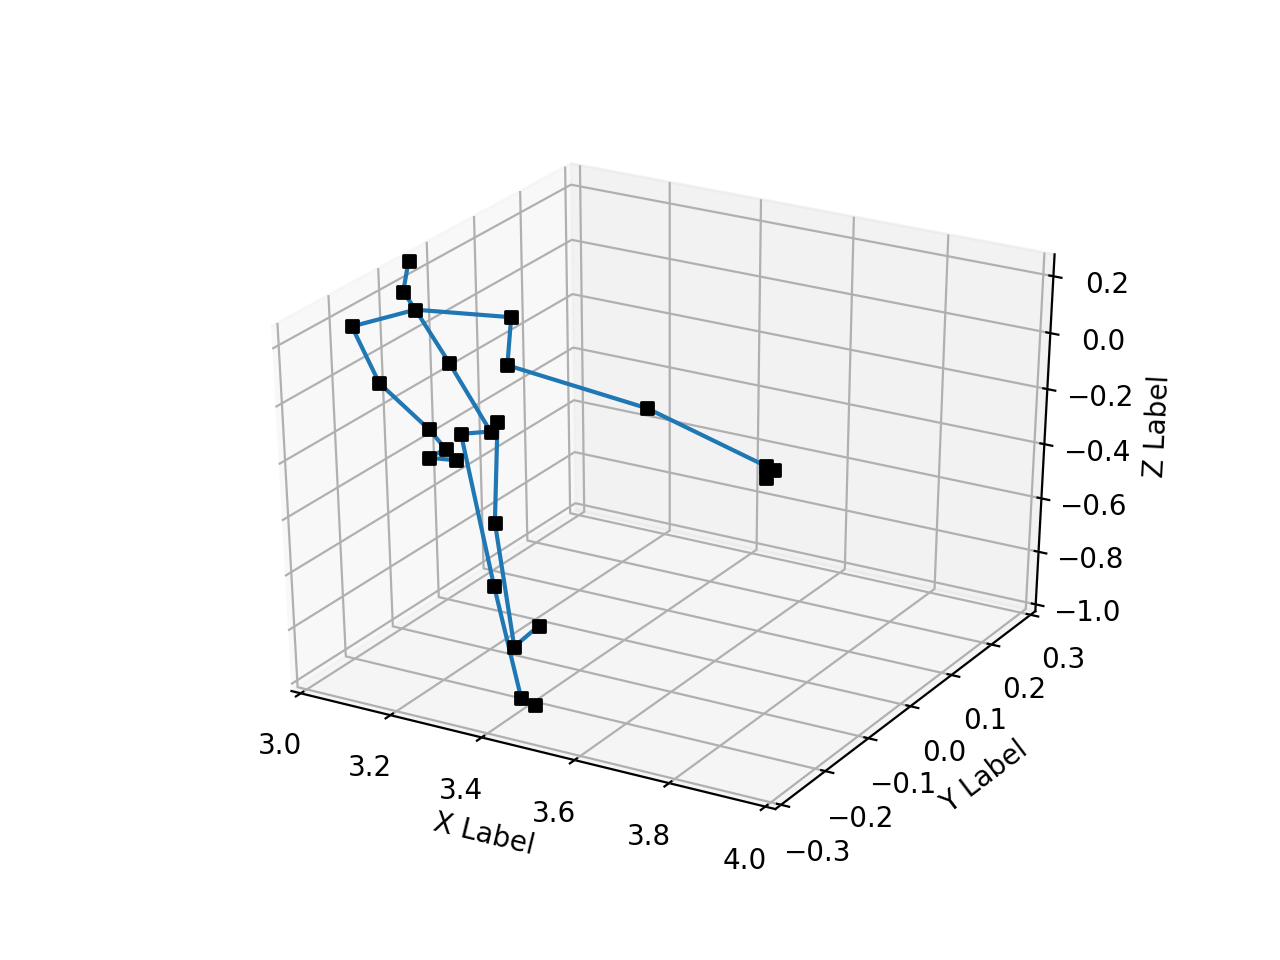

In [127]:
%matplotlib notebook

bone_pairs = (
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25),(25, 12)
)

i = 0
# for for_draw in skels_for_draw:
i = i + 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for_draw = skels_for_draw[10]

for pair in bone_pairs:
    xs = for_draw[pair[0]-1][0], for_draw[pair[1]-1][0]
    ys = for_draw[pair[0]-1][1], for_draw[pair[1]-1][1]
    zs = for_draw[pair[0]-1][2], for_draw[pair[1]-1][2]

    line = plt3d.art3d.Line3D(zs, xs, ys)
    ax.add_line(line)


for x,y,z in for_draw:
    ax.scatter(z, x, y, color='black', marker='s')

    ax.set_ylim((-0.3, 0.3))
    ax.set_zlim((-1.0, 0.25))
    ax.set_xlim((3.0, 4.0))


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')


    plt.show()

In [191]:
# Train test split
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),int(0.25*len(dataset))+1])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [192]:
class ActsLSTMnet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [193]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 3
rnn = ActsLSTMnet(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

ActsLSTMnet(
  (lstm): LSTM(75, 128, num_layers=3, batch_first=True)
  (dr): Dropout2d(p=0.25, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [194]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [195]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()

In [196]:
output = rnn(sket_tensor.to(device))

In [197]:
output.topk(5)

torch.return_types.topk(
values=tensor([[ 0.1484,  0.0530,  0.0186,  0.0131, -0.0037]], device='cuda:0',
       grad_fn=<TopkBackward>),
indices=tensor([[1, 4, 0, 6, 2]], device='cuda:0'))

In [199]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.4536  / handshaking ✗ (hugging other person)
epoch : 8 iter : 12 (0m 40s) 0.6969  / hugging other person ✓
epoch : 16 iter : 24 (1m 2s) 0.9991  / hugging other person ✓
epoch : 24 iter : 36 (1m 25s) 0.7173  / handshaking ✓
epoch : 32 iter : 48 (1m 46s) 0.1338  / typing on a keyboard ✓
epoch : 40 iter : 60 (2m 8s) 0.0092  / drink water ✓
epoch : 49 iter : 11 (2m 32s) 0.1613  / cross hands in front (say stop) ✓
epoch : 57 iter : 23 (2m 55s) 0.0910  / throw ✓
epoch : 65 iter : 35 (3m 15s) 0.0719  / drink water ✓
epoch : 73 iter : 47 (3m 35s) 0.3098  / cross hands in front (say stop) ✓
epoch : 81 iter : 59 (3m 54s) 0.0251  / pushing other person ✓
epoch : 90 iter : 10 (4m 12s) 0.0542  / pushing other person ✓
epoch : 98 iter : 22 (4m 30s) 0.1001  / drink water ✓
epoch : 106 iter : 34 (4m 48s) 0.2341  / point finger at the other person ✗ (pushing other person)
epoch : 114 iter : 46 (5m 8s) 0.0044  / drink water ✓
epoch : 122 iter : 58 (5m 29s) 0.0041  / nod head

<IPython.core.display.Javascript object>


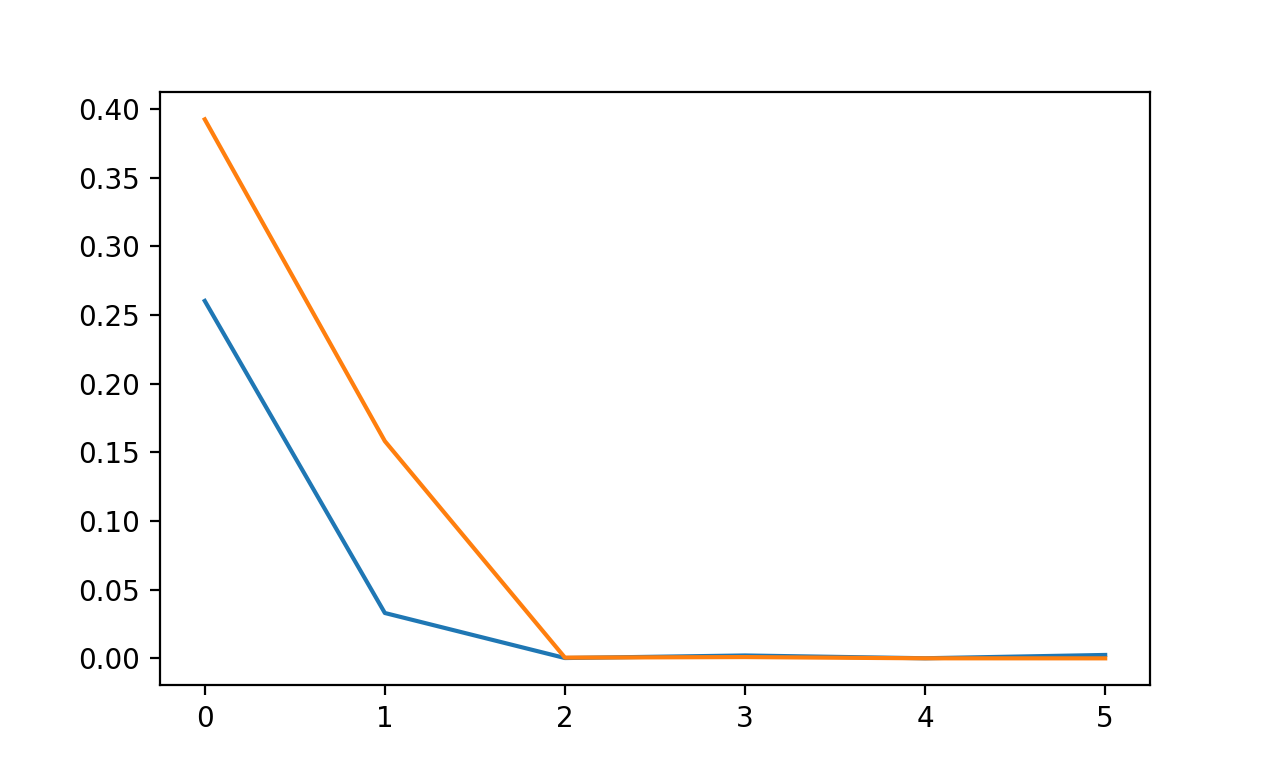

In [200]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [201]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   85.71428571428571


### Тест модели на датасете с меньшим количеством фреймов

In [202]:
assembler = DataAssembler(data_path=data_path,
                          broken_files_path=broken_files_path,
                          setting_params=assembling_settings,
                          chonk_len=25,
                          save_data=True)

action classes:  {1: 0, 7: 1, 30: 2, 35: 3, 40: 4, 43: 5, 52: 6, 54: 7, 55: 8, 58: 9}
action files:  {1: 120, 7: 120, 30: 120, 35: 120, 40: 120, 43: 120, 52: 120, 54: 120, 55: 120, 58: 120}



Successfully saved to data/1_7_30_35_40_43_52_54_55_58_.csv


In [209]:
dataset = Skeleton_Dataset(file_path="data/1_7_30_35_40_43_52_54_55_58_.csv",
                           transform=None,
                           chonk_len=25
                          )
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),int(0.25*len(dataset))+1])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [211]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 

        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.6176  / drink water ✗ (pushing other person)
epoch : 7 iter : 3 (0m 36s) 1.2344  / handshaking ✗ (throw)
epoch : 14 iter : 6 (1m 7s) 0.9602  / falling ✗ (nod head/bow)
epoch : 21 iter : 9 (1m 43s) 0.8746  / drink water ✓
epoch : 28 iter : 12 (2m 13s) 0.4106  / drink water ✓
epoch : 35 iter : 15 (2m 26s) 0.3512  / throw ✓
epoch : 42 iter : 18 (2m 39s) 0.5703  / point finger at the other person ✗ (handshaking)
epoch : 49 iter : 21 (2m 51s) 0.7230  / point finger at the other person ✗ (hugging other person)
epoch : 56 iter : 24 (3m 4s) 0.3998  / falling ✓
epoch : 63 iter : 27 (3m 17s) 0.8958  / point finger at the other person ✓
epoch : 70 iter : 30 (3m 29s) 0.2611  / cross hands in front (say stop) ✓
epoch : 77 iter : 33 (3m 42s) 0.0584  / throw ✓
epoch : 84 iter : 36 (3m 54s) 0.1849  / handshaking ✓
epoch : 91 iter : 39 (4m 7s) 0.1488  / handshaking ✓
epoch : 98 iter : 42 (4m 20s) 0.0209  / hugging other person ✓
epoch : 105 iter : 45 (4m 32s) 0.0573  / nod 

<IPython.core.display.Javascript object>


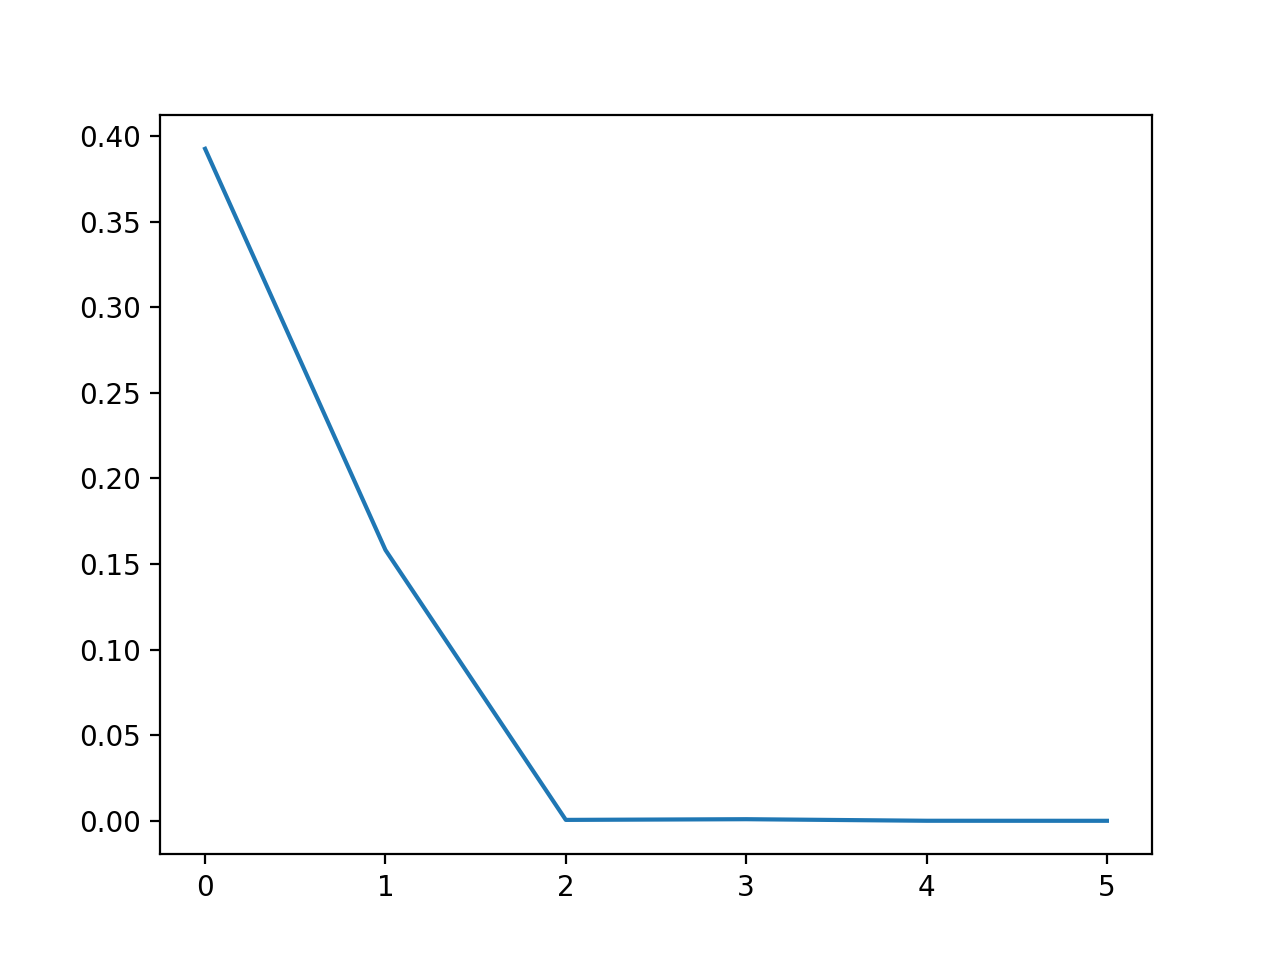

In [214]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [213]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   54.166666666666664
